In [1]:
from pennylane import numpy as np
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

### Setting the coordinates of H3 molecule

In [2]:
symbols = ["H", "H", "H"]
x = np.array([0.028, 0.054, 0.0, 0.986, 1.610, 0.0, 1.855, 0.002, 0.0], requires_grad=True)     #coordinates intialized

### Building the parametrized electronic Hamiltonian
Using Jordan-Wigner transformation

* We define the function H(x) to build the parametrized Hamiltonian of the trihydrogen cation using the molecular_hamiltonian() function.

In [3]:
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=1)[0]

### The variational quantum circuit

#### Number of Qubits we need 

The state of electrons in a molecule can then be described by specifying how the orbitals are occupied. The Jordan-Wigner representation provides a convenient way to do this: we associate a qubit with each spin orbital and use its states to represent occupied |1⟩ or unoccupied |0⟩ spin orbitals.


In [5]:
import pennylane as qml

In [6]:
hf = qml.qchem.hf_state(electrons=2, orbitals=6)
print(hf)                                               # i.e. 6 qubits needed : 6 orbitals and two occupied

[1 1 0 0 0 0]


* Building the paramatrized circuit
  * we use double excitations in the process. Double-qubit rotations involve operations that act on two qubits simultaneously, typically creating entanglement between them. 
  * now (theta) becomes the only optimizing parameter

In [7]:
num_wires = 6
dev = qml.device("lightning.qubit", wires=num_wires)


@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])                        # Double rotation applied  
    qml.DoubleExcitation(params[1], wires=[0, 1, 4, 5])                        # # Double rotation applied  

    return qml.expval(obs)

### The cost function and the nuclear gradients

Now we define the cost function  g
(
θ
,
x
)
=
⟨
Ψ
(
θ
)
|
H
(
x
)
|
Ψ
(
θ
)
⟩
 . It evaluates the expectation value of the parametrized Hamiltonian  H
(
x
)
  in the trial state  |
Ψ
(
θ
)
⟩
 .

In [8]:
def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(num_wires))    # using the cicuit function and replacing the observable as the hamiltonian of the system

### Gradient

In [9]:
def finite_diff(f, x, delta=0.01):
    """Compute the central-difference finite difference of a function"""
    gradient = []

    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        res = (f(x + shift) - f(x - shift)) * delta**-1
        gradient.append(res)

    return gradient


def grad_x(params, x):
    grad_h = finite_diff(H, x)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    return np.array(grad)

### Optimization of the molecular geometry

The goal of the variational algorithm is to find the global minimum of the cost function  g
(
θ
,
x
)
=
⟨
Ψ
(
θ
)
|
H
(
x
)
|
Ψ(θ
)
⟩ with respect to the circuit parameters θ and the nuclear coordinates x entering the electronic Hamiltonian of the molecule.

In [13]:
opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)          # cicuit paramter theta
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)              # nuclear coordinate x

In [14]:
theta = np.array([0.0, 0.0], requires_grad=True)

In [15]:
energy = []
bond_length = []

bohr_angs = 0.529177210903                              # to convert from Bohrs to Angstroms

for n in range(100):
    
    theta.requires_grad = True                       # Optimizing theta
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    x.requires_grad = True                               # Optimizing nuclear coordinates
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 2 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} A")

    if np.max(grad_x(theta, x)) <= 1e-05:                               # Checking maximum component of the nuclear gradient
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

Step = 0,  E = -1.26094338 Ha,  bond length = 0.96762 A
Step = 2,  E = -1.27115944 Ha,  bond length = 0.97155 A
Step = 4,  E = -1.27360653 Ha,  bond length = 0.97619 A
Step = 6,  E = -1.27421831 Ha,  bond length = 0.97982 A
Step = 8,  E = -1.27437809 Ha,  bond length = 0.98223 A
Step = 10,  E = -1.27442118 Ha,  bond length = 0.98371 A
Step = 12,  E = -1.27443305 Ha,  bond length = 0.98457 A
Step = 14,  E = -1.27443636 Ha,  bond length = 0.98506 A
Step = 16,  E = -1.27443729 Ha,  bond length = 0.98533 A
Step = 18,  E = -1.27443756 Ha,  bond length = 0.98548 A
Step = 20,  E = -1.27443763 Ha,  bond length = 0.98556 A
Step = 22,  E = -1.27443765 Ha,  bond length = 0.98561 A
Step = 24,  E = -1.27443766 Ha,  bond length = 0.98563 A

Final value of the ground-state energy = -1.27443766 Ha

Ground-state equilibrium geometry
symbol    x        y        z
  H    0.0102   0.0442   0.0000
  H    0.9867   1.6303   0.0000
  H    1.8720   -0.0085   0.0000


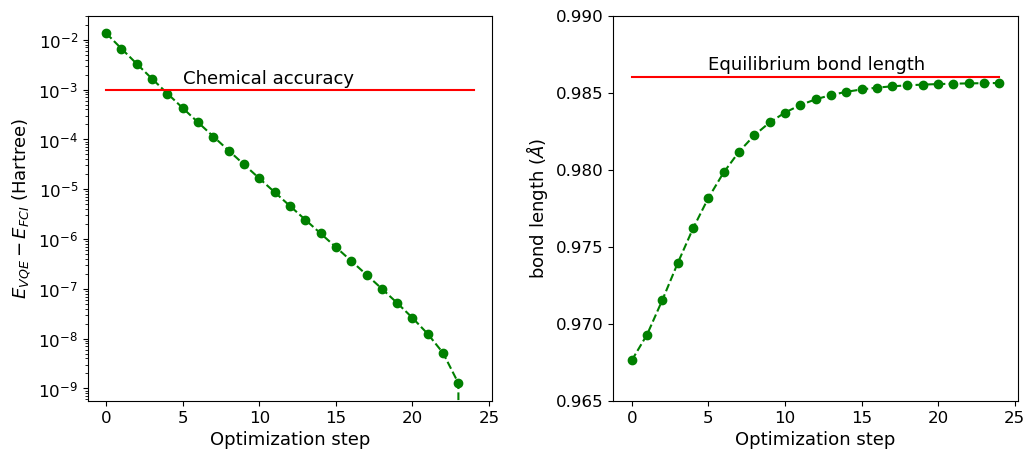

In [19]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# energy plot on column 1
E_fci = -1.27443765658
E_vqe = np.array(energy)
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 1), E_vqe - E_fci, "go-", ls="dashed")
ax1.plot(range(n + 1), np.full(n + 1, 0.001), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("$E_{VQE} - E_{FCI}$ (Hartree)", fontsize=13)
ax1.text(5, 0.0013, r"Chemical accuracy", fontsize=13)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# bond length plot on column 2
d_fci = 0.986
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 1), bond_length, "go-", ls="dashed")
ax2.plot(range(n + 1), np.full(n + 1, d_fci), color="red")
ax2.set_ylim([0.965, 0.99])
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
ax2.text(5, 0.9865, r"Equilibrium bond length", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()

* We finally find value of the ground-state energy = -1.27443766 Ha